<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/main/fyp_GRU_netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=5176a20212fb993c78d9cce287a91b67bbbe08a62ee45ab8d2e9aeb389ba02c6
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
 # Module import
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import median_abs_deviation
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
from tensorflow.keras.optimizers import Nadam, RMSprop
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [3]:
df = yf.download(tickers=['NFLX'], start='2012-01-01', end='2022-06-20')

df_3 = df.dropna()
df_3

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,10.040000,10.388571,10.018571,10.320000,10.320000,29213800
2012-01-04,10.335714,11.567143,10.258571,11.492857,11.492857,100489900
2012-01-05,11.345714,11.694286,11.040000,11.328571,11.328571,86552900
2012-01-06,11.302857,12.471429,11.242857,12.327143,12.327143,125610800
2012-01-09,12.801429,14.235714,12.448571,14.025714,14.025714,214073300
...,...,...,...,...,...,...
2022-06-13,177.070007,179.089996,168.960007,169.690002,169.690002,10222400
2022-06-14,169.750000,172.059998,164.279999,167.539993,167.539993,11555300
2022-06-15,169.259995,183.850006,168.529999,180.110001,180.110001,12396000


In [4]:
# Stock indicators for Processing

df_3['RSI']=ta.rsi(df_3.Close, length=15)
df_3['EMAF']=ta.ema(df_3.Close, length=20)
df_3['EMAM']=ta.ema(df_3.Close, length=100)
df_3['EMAS']=ta.ema(df_3.Close, length=150)

df_3['Target'] = df_3['Adj Close']-df_3.Open
df_3['Target'] = df_3['Target'].shift(-1)

df_3['TargetClass'] = [1 if df_3.Target[i]>0 else 0 for i in range(len(df_3))]

df_3['Target Adj Close'] = df_3['Adj Close'].shift(-1)

df_3.dropna(inplace=True)
df_3.reset_index(inplace = True)
df_3.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
df_3


<ipython-input-4-c6e0b158a695>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_3['TargetClass'] = [1 if df_3.Target[i]>0 else 0 for i in range(len(df_3))]


,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,Target Adj Close
0,7.791429,8.167143,7.730000,8.112857,33.687547,9.326657,11.581611,12.993457,0.135715,1,8.271429
1,8.135714,8.495714,8.078571,8.271429,35.851662,9.226159,11.516063,12.930914,0.032857,1,8.257143
2,8.224286,8.412857,8.167143,8.257143,35.739078,9.133872,11.451530,12.869009,0.045713,1,8.272857
3,8.227143,8.350000,8.178571,8.272857,35.976018,9.051871,11.388586,12.808133,0.320001,1,8.557143
4,8.237143,8.651429,8.128571,8.557143,40.246686,9.004754,11.332518,12.751829,-0.187143,0,8.558571
...,...,...,...,...,...,...,...,...,...,...,...
2478,182.639999,185.860001,180.850006,182.940002,38.506810,196.635801,309.504954,360.574521,-7.380005,0,169.690002
2479,177.070007,179.089996,168.960007,169.690002,33.958637,194.069535,306.736341,358.046249,-2.210007,0,167.539993
2480,169.750000,172.059998,164.279999,167.539993,33.275339,191.542912,303.979977,355.522988,10.850006,1,180.110001
2481,169.259995,183.850006,168.529999,180.110001,40.744114,190.454063,301.527107,353.199637,-0.649994,0,173.350006


In [5]:
df_4 = df_3.iloc[:, 0:11]
pd.set_option('display.max_columns', None)
df_4.head(10)
df_4

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,Target Adj Close
0,7.791429,8.167143,7.730000,8.112857,33.687547,9.326657,11.581611,12.993457,0.135715,1,8.271429
1,8.135714,8.495714,8.078571,8.271429,35.851662,9.226159,11.516063,12.930914,0.032857,1,8.257143
2,8.224286,8.412857,8.167143,8.257143,35.739078,9.133872,11.451530,12.869009,0.045713,1,8.272857
3,8.227143,8.350000,8.178571,8.272857,35.976018,9.051871,11.388586,12.808133,0.320001,1,8.557143
4,8.237143,8.651429,8.128571,8.557143,40.246686,9.004754,11.332518,12.751829,-0.187143,0,8.558571
...,...,...,...,...,...,...,...,...,...,...,...
2478,182.639999,185.860001,180.850006,182.940002,38.506810,196.635801,309.504954,360.574521,-7.380005,0,169.690002
2479,177.070007,179.089996,168.960007,169.690002,33.958637,194.069535,306.736341,358.046249,-2.210007,0,167.539993
2480,169.750000,172.059998,164.279999,167.539993,33.275339,191.542912,303.979977,355.522988,10.850006,1,180.110001
2481,169.259995,183.850006,168.529999,180.110001,40.744114,190.454063,301.527107,353.199637,-0.649994,0,173.350006


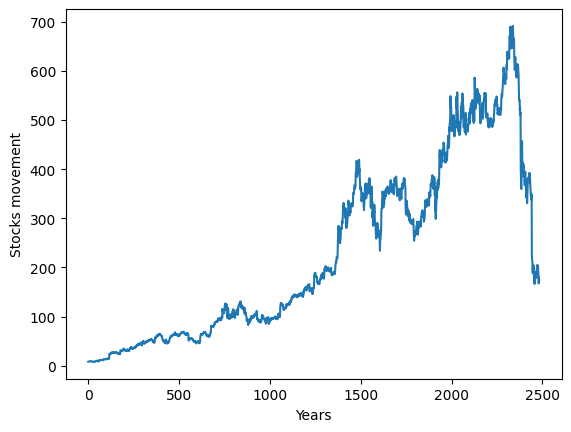

In [6]:
df_4_AC=df_4['Adj Close']
plt.ylabel('Stocks movement')
plt.xlabel('Years')
plt.plot(df_4_AC)

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
df_4_scaled = sc.fit_transform(df_3)
print(df_4_scaled)

[[1.14764846e-04 3.07136802e-04 2.23178511e-04 ... 4.37039193e-01
  1.00000000e+00 8.56303540e-04]
 [6.17636403e-04 7.81241263e-04 7.36907936e-04 ... 4.35984342e-01
  1.00000000e+00 8.35417646e-04]
 [7.47007861e-04 6.61684462e-04 8.67445966e-04 ... 4.36116189e-01
  1.00000000e+00 8.58390735e-04]
 ...
 [2.36675954e-01 2.36792579e-01 2.30948832e-01 ... 5.46918072e-01
  1.00000000e+00 2.52080710e-01]
 [2.35960238e-01 2.53804701e-01 2.37212543e-01 ... 4.28981462e-01
  0.00000000e+00 2.42197739e-01]
 [2.42883622e-01 2.42867311e-01 2.41678199e-01 ... 4.54927347e-01
  1.00000000e+00 2.45355597e-01]]


In [8]:
# Multiple feature for data
X = []

backcandles = 40
print(df_4_scaled.shape[0])
for j in range(8):  # Targeted columns 2
    X.append([])
    for i in range(backcandles, df_4_scaled.shape[0]):#backcandles+2
        X[j].append(df_4_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(df_4_scaled[backcandles:,-1]) #scaling backwards
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2483
[[[1.14764846e-04 3.07136802e-04 2.23178511e-04 ... 1.77856240e-03
   3.13731431e-03 3.86675221e-03]
  [6.17636403e-04 7.81241263e-04 7.36907936e-04 ... 1.62617446e-03
   3.02825898e-03 3.75939072e-03]
  [7.47007861e-04 6.61684462e-04 8.67445966e-04 ... 1.48623657e-03
   2.92089251e-03 3.65312642e-03]
  ...
  [3.90196853e-04 8.65755435e-05 2.33705998e-04 ... 1.03123913e-04
   3.90260654e-04 8.26718552e-04]
  [2.19094307e-04 2.67964549e-05 2.46338280e-04 ... 3.89205503e-05
   3.19317969e-04 7.48384167e-04]
  [1.27284102e-04 1.89641372e-04 2.71603546e-04 ... 1.40466261e-05
   2.57357537e-04 6.76316674e-04]]

 [[6.17636403e-04 7.81241263e-04 7.36907936e-04 ... 1.62617446e-03
   3.02825898e-03 3.75939072e-03]
  [7.47007861e-04 6.61684462e-04 8.67445966e-04 ... 1.48623657e-03
   2.92089251e-03 3.65312642e-03]
  [7.51181179e-04 5.70986863e-04 8.84288540e-04 ... 1.36189535e-03
   2.81616980e-03 3.54862687e-03]
  ...
  [2.19094307e-04 2.67964549e-05 2.46338280e-04 ... 3.89205503e-05
   3.

In [9]:
# split data into training and testing
train_test_split = int(len(X)*0.7)
print(train_test_split)
X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1710
(1710, 40, 8)
(733, 40, 8)
(1710, 1)
(733, 1)
[[0.00183374]
 [0.00268795]
 [0.00266498]
 ...
 [0.44943328]
 [0.4428836 ]
 [0.43802982]]


In [10]:
# Define the input shape
input_shape = (backcandles, 8)
input_layer = layers.Input(shape=input_shape, name='Input')

# GRU Layer 1
gru_1 = layers.GRU(units=100, return_sequences=True, activation='tanh',
                   kernel_regularizer=regularizers.l2(0.001), dropout=0.1, recurrent_dropout=0.1)(input_layer)

# Additional GRU Layer
gru_2 = layers.GRU(units=50, return_sequences=False, activation='tanh')(gru_1)

# Dense Layer
dense_1 = layers.Dense(units=50, activation='relu')(gru_2)

# Output Layer
output_layer = layers.Dense(1, activation='linear')(dense_1)


# Create the model
gru_model = models.Model(inputs=input_layer, outputs=output_layer, name='GRU_Model')
gru_model.summary()


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 40, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 40, 100)             │          33,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,401 (228.13 KB)

 Trainable params: 58,401 (228.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


In [12]:
# Train the model
history = gru_model.fit( X_train,
    y_train,
    batch_size=64,
    epochs=128,
    validation_data=(X_test, y_test),
    verbose=1,)

print(history.history.keys)

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0234 - mean_absolute_error: 0.0665 - val_loss: 0.0221 - val_mean_absolute_error: 0.0951
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0109 - mean_absolute_error: 0.0235 - val_loss: 0.0229 - val_mean_absolute_error: 0.1113
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0077 - mean_absolute_error: 0.0193 - val_loss: 0.0172 - val_mean_absolute_error: 0.0951
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0059 - mean_absolute_error: 0.0174 - val_loss: 0.0176 - val_mean_absolute_error: 0.1028
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0048 - mean_absolute_error: 0.0168 - val_loss: 0.0171 - val_mean_absolute_error: 0.1047
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0039 - mean_absolute_error: 0.0141 - val_loss: 0.0173 - val_mean_absolute_error: 0.1085
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0034 - mean_absolute_error: 0.0138 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
[0.40603074] [0.4535853]
[0.40521494] [0.46604134]
[0.41334113] [0.479667]
[0.4243889] [0.47516412]
[0.4367497] [0.4652665]
[0.43788996] [0.46096827]
[0.42943963] [0.45586598]
[0.42399377] [0.45488644]
[0.42151946] [0.4385123]
[0.41576603] [0.44212339]


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

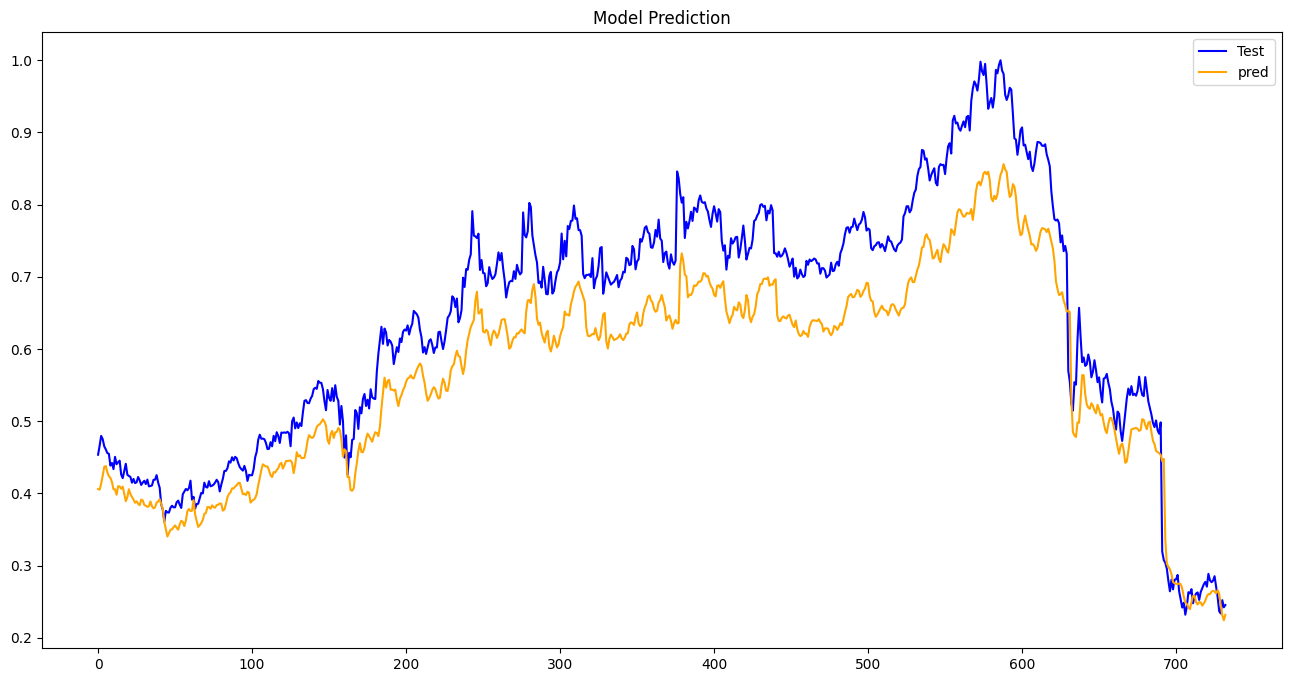

In [13]:
# Make predictions on test data

# Model prediction
y_pred = gru_model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

    plt.figure(figsize=(16,8))


plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'orange', label = 'pred')
plt.legend(loc=0)
plt.title('Model Prediction')
plt.show()

In [14]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.017736,0.045481,0.022140,0.095083
1,0.009935,0.021427,0.022912,0.111306
2,0.007208,0.018935,0.017171,0.095070
3,0.005570,0.016704,0.017562,0.102796
4,0.004546,0.016055,0.017079,0.104748


In [15]:
# Evaluate the model
loss = gru_model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the loss value from the list
y_pred = gru_model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))  # Calculate MAE manually

print(f"Test loss: {loss:.4f}, Test MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test loss: 0.0068, Test MAE: 0.0729


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0729
Mean Squared Error (MSE): 0.0067
Root Mean Squared Error (RMSE): 0.0820
R-squared (R2) score: 0.7859


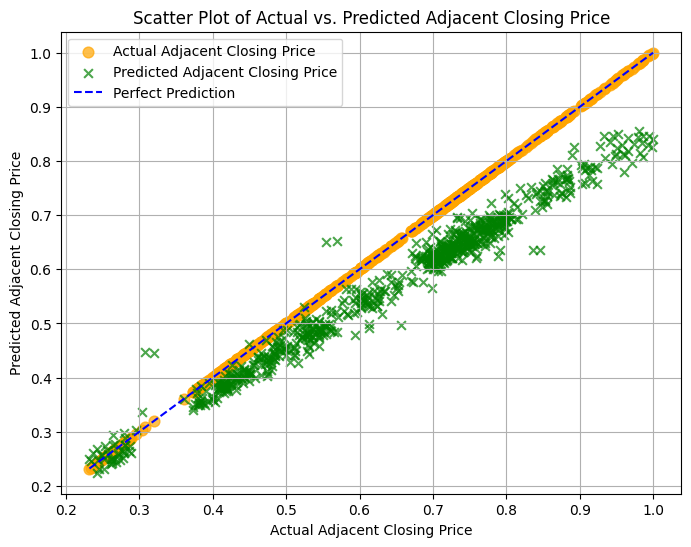

In [17]:
# Scatter plot of actual vs. predicted adjacent closing prices
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

# Plot actual values as orange circles with larger markers
plt.scatter(y_test, y_test, color='orange', label='Actual Adjacent Closing Price', alpha=0.7, s=60)

# Plot predicted values as black crosses with smaller markers
plt.scatter(y_test, y_pred, color='green', label='Predicted Adjacent Closing Price', alpha=0.7, s=40, marker='x')

# Plot the diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Adjacent Closing Price')
plt.ylabel('Predicted Adjacent Closing Price')
plt.title('Scatter Plot of Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

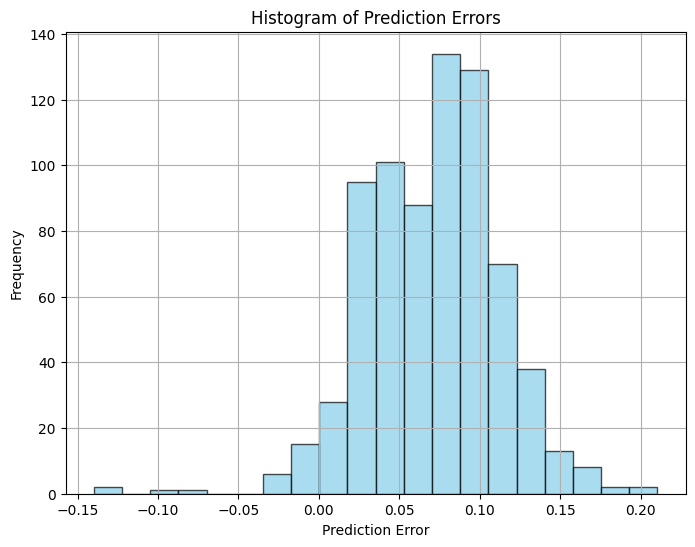

In [18]:
# Histogram of prediction errors
errors = y_test - y_pred

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add grid lines for better readability
plt.grid(True)

plt.show()